<a href="https://colab.research.google.com/github/juanfranbrv/curso-langchain/blob/main/Agente%20con%20tools.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
%%capture --no-stderr

# Importar la librería `userdata` de Google Colab.
# Esta librería se utiliza para acceder a datos de usuario almacenados de forma segura en el entorno de Colab.
from google.colab import userdata

# Obtener las claves API de diferentes servicios desde el almacenamiento seguro de Colab.
OPENAI_API_KEY=userdata.get('OPENAI_API_KEY')
# GROQ_API_KEY=userdata.get('GROQ_API_KEY')
# GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')
# HUGGINGFACEHUB_API_TOKEN=userdata.get('HUGGINGFACEHUB_API_TOKEN')

# El flag `-qU` instala en modo silencioso (`-q`) y actualiza las librerías si ya están instaladas (`-U`).
%pip install langchain -qU  # Instalar la librería principal de LangChain.
%pip install langgraph -qU

# Instalar las integraciones de LangChain con diferentes proveedores de LLMs.
%pip install langchain-openai -qU
# %pip install langchain-groq -qU
# %pip install langchain-google-genai -qU
# %pip install langchain-huggingface -qU

# Importar las clases necesarias de LangChain para crear plantillas de prompt.
# `ChatPromptTemplate` es la clase base para plantillas de chat.
from langchain.prompts import ChatPromptTemplate


# Importamos las clases necesarias para trabajar con cadenas
from langchain.chains import LLMChain

# Importar las clases para interactuar con los diferentes LLMs a través de LangChain.
from langchain_openai import ChatOpenAI
# from langchain_groq import ChatGroq
# from langchain_google_genai import ChatGoogleGenerativeAI
# from langchain_huggingface import HuggingFaceEndpoint

# Importamos la libreria para formatear mejor la salida
from IPython.display import Markdown, display

# Para la anotacion de tipos
from typing import Literal

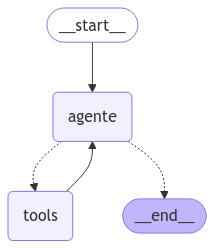

================================ Human Message =================================

Cuantas veces se menciona fresa en la frase: Una fresa es de color fresa
================================== Ai Message ==================================
Tool Calls:
  frecuencia_palabra (call_2Jpjp10bUylAy7XkKHdyxlFI)
 Call ID: call_2Jpjp10bUylAy7XkKHdyxlFI
  Args:
    texto: Una fresa es de color fresa
    palabra: fresa
================================= Tool Message =================================
Name: frecuencia_palabra

2
================================== Ai Message ==================================

La palabra "fresa" se menciona 2 veces en la frase "Una fresa es de color fresa".


In [23]:
from langgraph.graph import END, START, StateGraph, MessagesState
from langgraph.prebuilt import tools_condition, ToolNode
from langchain.agents import tool


from IPython.display import Image, display


# 1. DEFINIMOS EL ESQUEMA DEL ESTADO ===========================================
# Siempre es algun tipo de diccionario

class MyState(MessagesState):
    # Hereda de MessagesState, que internamente guarda "messages"
    # messages: list[AnyMessage]
    # Podemos añadir campos extra si queremos
    pass

# 2. INSTANCIAMOS UN GRAFO =====================================================
# Lo hacemos pasándole el tipo del estado al constructor

grafo = StateGraph(MyState)

# 3. CREAMOS LAS HERRAMIENTAS / FUNCIONES AUXILIARES ===========================
# Funciones para nodos, arista condicionales y herramientas

# Definir las herramientas
@tool
def contiene_numeros(texto: str) -> bool:
    """Verifica si el texto contiene números."""
    return any(caracter.isdigit() for caracter in texto)

@tool
def contar_caracteres(texto: str) -> int:
    """Cuenta el número total de caracteres en un texto, incluyendo espacios."""
    return len(texto)

@tool
def contar_caracteres_sin_espacios(texto: str) -> int:
    """Cuenta el número de caracteres en un texto, excluyendo espacios."""
    return len(texto.replace(" ", ""))

@tool
def frecuencia_palabra(texto: str, palabra: str) -> int:
    """Cuenta cuántas veces aparece una palabra específica en un texto."""
    return texto.lower().split().count(palabra.lower())

@tool
def frecuencia_letra(texto: str, letra: str) -> int:
    """Cuenta cuántas veces aparece una letra específica en un texto."""
    return texto.lower().count(letra.lower())

# Esta funcion es un nodo
# Recibe el estado e invoca al LLM con los mensajes
def agente(state: MyState) -> MyState:
   return {"messages": [modelo_con_herramientas.invoke(state["messages"])]}

# 4. INSTANCIAMOS EL MODELO Y LE AÑADIMOS LAS HERRAMIENTAS =====================

herramientas = [contiene_numeros,
                contar_caracteres,
                contar_caracteres_sin_espacios,
                frecuencia_palabra,
                frecuencia_letra]

modelo = ChatOpenAI(model="gpt-4o-mini", api_key=OPENAI_API_KEY, temperature=0)

modelo_con_herramientas = modelo.bind_tools(herramientas)


# 5. AÑADIMOS NODOS AL GRAFO ===================================================
# Usamos la sintaxis graph.add_node(nombre, runnable)
# nombre: el nombre del nodo
# runnable: función o un ejecutable LCEL que se llamará al entrar al nodo
# Esta función/LCEL debe aceptar un diccionario en el mismo formato que el ESTADO como entrada
# Y devolver un diccionario tambien con el mismo formato que el estado, que sera el nuevo estado.

# Añadimos el nodo y su arista en el grafo
grafo.add_node("agente", agente)
grafo.add_node("tools", ToolNode(herramientas))

# Toolcondition redirecciona a un nodo por defcto que se tiene que llmar tools


# 5. LÓGICA Y ARISTAS ==========================================================
# El nodo inicial lo definimos haciendo uso de START

grafo.add_edge(START, "agente")

# Las aristas condicionales se definen usando el método
# add_conditional_edges (nodo_origen, funcion)
# La funcion de condicion se encarga de decidir (basandose en el estado) el nodo siguiente
# DeBe devolver el nombre del nodo destino (str)

grafo.add_conditional_edges("agente",tools_condition)
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END


# Cualquier arista no condicional la creamos
# grafo.add(nodo1, nodo2)

grafo.add_edge("tools", "agente")

# 6. COMPILAMOS EL GRAFO =======================================================
# Esto crea un LangChain Runnable
# lo que implica que lo podemos usar como cualquier otro Runnable
app = grafo.compile()

# Show
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

# 7. EJECUTAMOS EL RUNNABLE ====================================================
pregunta = "Cuantas veces se menciona fresa en la frase: Una fresa es de color fresa"
respuesta = app.invoke({"messages": pregunta})
for m in respuesta['messages']:
    m.pretty_print()






# Refs
# https://github.com/olonok69/LLM_Notebooks/blob/main/langchain/langgraph/LangGraph_agent_memory.ipynb
# https://anderfernandez.com/blog/sistemas-de-agente-con-langgraph/
# https://github.com/langchain-ai/langgraph/tree/main
# https://blog.langchain.dev/langgraph/

In [10]:
# Ejemplo de agente con LangGraph: múltiples nodos, herramientas y arista condicional

from typing import Literal
from langchain.agents import tool
from langchain_openai import ChatOpenAI
from langgraph.graph import START, END, StateGraph, MessagesState

# =============================================================================
# 1. DEFINIMOS EL ESQUEMA DEL ESTADO
# =============================================================================
class MyMessagesState(MessagesState):
    # Hereda de MessagesState, que internamente guarda "messages"
    # Podemos añadir campos extra si queremos
    detalle_extra: str = ""

# Instanciamos el grafo
grafo = StateGraph(MyMessagesState)

# =============================================================================
# 2. DEFINIMOS LAS HERRAMIENTAS (TOOLS)
# =============================================================================
@tool
def traducir_ingles(texto: str) -> str:
    """Traducción *simple* (dummy) al inglés"""
    return f"(Traducción dummy al inglés): {texto}"

@tool
def traducir_espanol(texto: str) -> str:
    """Traducción *simple* (dummy) al español"""
    return f"(Traducción dummy al español): {texto}"

@tool
def revertir_texto(texto: str) -> str:
    """Revierte el texto (lo escribe al revés)."""
    return texto[::-1]

# =============================================================================
# 3. DEFINIMOS LOS NODOS Y LA LÓGICA DEL GRAFO
# =============================================================================

def agente(state: MyMessagesState) -> MyMessagesState:
    """
    Nodo inicial: aquí podrías hacer configuraciones, etc.
    En este ejemplo, simplemente seguimos para que 'router' decida.
    """
    # Podrías hacer algo con state.messages[-1], si quisieras.
    return state

def router(state: MyMessagesState) -> Literal["traducir_en",
                                              "traducir_es",
                                              "revertir",
                                              "desconocido"]:
    """
    A partir del último mensaje del usuario, decide qué nodo sigue.
    - Si detecta 'english' -> traducir_en
    - Si detecta 'espanol' o 'spanish' -> traducir_es
    - Si detecta 'revertir' -> revertir
    - En caso contrario -> desconocido
    """
    user_msg = state.messages[-1][1].lower()  # Contenido del último mensaje

    if "english" in user_msg or "inglés" in user_msg:
        return "traducir_en"
    elif "spanish" in user_msg or "español" in user_msg:
        return "traducir_es"
    elif "revertir" in user_msg or "reverse" in user_msg:
        return "revertir"
    else:
        return "desconocido"

def traducir_en(state: MyMessagesState) -> MyMessagesState:
    """Nodo para traducir al inglés."""
    user_msg = state.messages[-1][1]
    resultado = traducir_ingles.run(user_msg)
    # Agregamos la respuesta de la IA
    state.messages.append(("ai", resultado))
    return state

def traducir_es(state: MyMessagesState) -> MyMessagesState:
    """Nodo para traducir al español."""
    user_msg = state.messages[-1][1]
    resultado = traducir_espanol.run(user_msg)
    state.messages.append(("ai", resultado))
    return state

def revertir(state: MyMessagesState) -> MyMessagesState:
    """Nodo para revertir el texto."""
    user_msg = state.messages[-1][1]
    resultado = revertir_texto.run(user_msg)
    state.messages.append(("ai", f"Texto revertido: {resultado}"))
    return state

def desconocido(state: MyMessagesState) -> MyMessagesState:
    """Nodo de fallback si no se reconoce la petición."""
    state.messages.append(("ai", "Lo siento, no entendí tu petición."))
    return state

# =============================================================================
# 4. CONFIGURAMOS EL MODELO (LLM) CON LAS HERRAMIENTAS
# =============================================================================
# En tu caso, "gpt-4o-mini" existe y es válido.
# Aquí lo dejamos, o puedes cambiarlo por un modelo real como "gpt-3.5-turbo".
OPENAI_API_KEY = "TU_API_KEY"  # Asegúrate de inyectarla
modelo = ChatOpenAI(model="gpt-4o-mini", api_key=OPENAI_API_KEY, temperature=0)

modelo_con_herramientas = modelo.bind_tools([
    traducir_ingles,
    traducir_espanol,
    revertir_texto
])

# =============================================================================
# 5. AÑADIMOS LOS NODOS Y LAS ARISTAS AL GRAFO
# =============================================================================
grafo.add_node("agente", agente)
grafo.add_node("traducir_en", traducir_en)
grafo.add_node("traducir_es", traducir_es)
grafo.add_node("revertir", revertir)
grafo.add_node("desconocido", desconocido)

# Aristas:
# - START -> agente
grafo.add_edge(START, "agente")

# - agente -> router (arista condicional)
grafo.add_conditional_edges("agente", router)

# No hace falta crear edges a la inversa, porque queremos que el flujo
# termine en alguno de los nodos finales, pero si lo deseas, podrías
# conectar con "agente" de nuevo. Aquí lo dejamos lineal.

# =============================================================================
# 6. COMPILAMOS EL GRAFO EN UN RUNNABLE
# =============================================================================
app = grafo.compile()

# =============================================================================
# 7. EJECUTAMOS UN EJEMPLO
# =============================================================================
# Mensaje de ejemplo para "revertir" texto
pregunta = MyMessagesState(
    messages=[
        ("system", "Eres un agente que puede traducir al inglés, español o revertir texto."),
        ("human", "Por favor, revertir este texto: Hola Mundo!")
    ]
)

estado_respuesta = app.invoke(pregunta)
estado_respuesta.pretty_print()

# También podemos invocar otra pregunta:
pregunta_2 = MyMessagesState(
    messages=[
        ("system", "Eres un agente que puede traducir al inglés, español o revertir texto."),
        ("human", "¿Puedes traducir esto a English? 'Hola, me encanta programar.'")
    ]
)

estado_respuesta_2 = app.invoke(pregunta_2)
estado_respuesta_2.pretty_print()


AttributeError: 'dict' object has no attribute 'messages'